In [15]:
pip install notebook --upgrade

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install --upgrade setuptools

In [17]:
pip install --upgrade google-api-python-client

In [18]:
pip install --upgrade wordcloud 

  Using cached wordcloud-1.8.2.2.tar.gz (220 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for wordcloud: started
  Running setup.py install for wordcloud: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: wordcloud is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  × Running setup.py install for wordcloud did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      running install
      c:\Users\dayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\wordcloud
      copying wordcloud\color_from_image.py -> build\lib.w

In [19]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install isodate

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install IPython

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install os

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [26]:
pip install matplotlib

In [27]:
import os

from os import path
#from wordcloud import WordCloud
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
api_key = 'coloque_sua_chave'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
channel_ids = ['UCUFFHXvzAMRSD8Bq4bJppxQ', 
                'UCoOae5nYA7VqaXzerajD0lg']

In [29]:
    api_service_name = "youtube"
    api_version = "v3"

    # Get credentials and create an API client

    youtube = build(
        api_service_name, api_version, developerKey=api_key)

In [30]:
def get_channel_stats(self, channel_ids):
    """
     Obter estatísticas do canal
    
     Parâmetros:
     ------
     youtube: objeto de construção da API do Youtube
     channel_ids: lista de IDs de canais
    
     Retorna:
     ------
     dataframe com todas as estatísticas de canal para cada ID de canal
    
     """
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
        
    )
    response = request.execute()
    
    #loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
              'subscribers': item['statistics']['subscriberCount'],
              'views': item['statistics']['viewCount'],
              'totalviews': item['statistics']['videoCount'],
              'playlistId':item['contentDetails']['relatedPlaylists']['uploads']
            
        }
        all_data.append(data)
    return (pd.DataFrame(all_data))
    

In [31]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [32]:
channel_stats

,channelName,subscribers,views,totalviews,playlistId
0,Ali Abdaal,3840000,274636804,570,UUoOae5nYA7VqaXzerajD0lg
1,Elizabeth Filips,654000,28440036,119,UUUFFHXvzAMRSD8Bq4bJppxQ


In [33]:
   playlist_id = 'UUUFFHXvzAMRSD8Bq4bJppxQ'
   
   def get_video_ids(youtube, playlist_id):
   
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_toke = response.get('nextPageToken')
    while next_page_toke is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_toke
    )
        response = request.execute()
    
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        next_page_toke = response.get('nextPageToken')
    return video_ids

In [34]:
video_ids = get_video_ids(youtube, playlist_id)

In [35]:
len(video_ids)

119

In [36]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [37]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,DXveBVRbP0Y,Elizabeth Filips,A Day in the Life of a Medical Student in Lond...,First day in the life in a LONG time 🫀\n\nWHO ...,None,2023-02-12T15:21:19Z,16165,1209,None,40,PT17S,hd,false
1,1tOcYYGHCO0,Elizabeth Filips,You Don't Hate Books: The Reading Habit Gettin...,Join my book club and ad-free educational YouT...,"[reading, books, how to read, how to read fast...",2023-02-07T11:30:02Z,50177,3108,None,190,PT14M41S,hd,false
2,FzONG60QwzE,Elizabeth Filips,Become a Better Student: The Simple But Clever...,I’m not saying we’re better as medical student...,None,2023-01-23T10:39:42Z,128662,7593,None,166,PT14M33S,hd,false
3,HPYIg4fJgwo,Elizabeth Filips,"Multipliers: 5 Easy, High-Leverage Changes I'm...",🧠 To get 20% off the Annual Membership for Bri...,None,2023-01-03T13:27:17Z,132437,6732,None,405,PT14M9S,hd,false
4,fi5Dbzxfjvc,Elizabeth Filips,Heal Yourself: 1 Life Formula from 620 Hours o...,Main Relevant links:\n📚 My Book Club through C...,None,2022-12-13T11:20:55Z,409865,21991,None,988,PT38M31S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,vTrq1akLC9A,Elizabeth Filips,STUDY WITH ME: 1h Get Something Done Today,Just going to leave this here for anyone who f...,"[Study with me, Work with me, Study with me wi...",2020-11-29T08:54:09Z,34978,807,None,81,PT1H1M9S,hd,false
115,42rUMksq4D4,Elizabeth Filips,How I Use Anki Flashcards in Medical School,To Save You Some Time:\n0:00 - 1- 🌝Intro\n0:12...,"[anki, flashcards, anki flashcards, anki medic...",2020-11-27T13:13:10Z,42175,1678,None,95,PT3M56S,hd,false
116,pakxdMxFEoc,Elizabeth Filips,Medical School Interview Tips,To save you some time:\n0:00 - Intro - 💁‍♀️ Wh...,"[medicine, medical interviews, medicine uk, me...",2020-11-24T12:19:25Z,7977,305,None,21,PT6M54S,hd,false
117,HH6as4fXQmg,Elizabeth Filips,How to Take Notes at University with Active Re...,Heya! This is a summary of the methods I've be...,"[anki, notion, medical students, medicine, stu...",2020-11-19T10:06:46Z,77436,3974,None,145,PT5M48S,hd,false


In [38]:
def get_comments_in_videos(youtube, video_ids):
    all_comments = []
    
    for video_id in video_ids:
        request = youtube.commentThreads().list(
            part="snippet,replies",
            videoId=video_id
        )
        response = request.execute()
        
        get_comments_in_videos = [comment ['snippet']['topLevelComment']['snippet']['textOriginal']for comment in response]
        get_comments_in_videos_info = {'video_id': video_id, 'comment': get_comments_in_videos}
        
        all_comments.append(get_comments_in_videos_info)
        
        return pd.DataFrame(all_comments)

In [39]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [40]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [41]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [42]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [43]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [44]:
video_df[['durationSecs','duration']]

,durationSecs,duration
0,17.0,PT17S
1,881.0,PT14M41S
2,873.0,PT14M33S
3,849.0,PT14M9S
4,2311.0,PT38M31S
...,...,...
114,3669.0,PT1H1M9S
115,236.0,PT3M56S
116,414.0,PT6M54S
117,348.0,PT5M48S


In [45]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [46]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,DXveBVRbP0Y,Elizabeth Filips,A Day in the Life of a Medical Student in Lond...,First day in the life in a LONG time 🫀\n\nWHO ...,None,2023-02-12 15:21:19+00:00,16165.0,1209.0,NaN,40.0,PT17S,hd,false,Sunday,17.0,0
1,1tOcYYGHCO0,Elizabeth Filips,You Don't Hate Books: The Reading Habit Gettin...,Join my book club and ad-free educational YouT...,"[reading, books, how to read, how to read fast...",2023-02-07 11:30:02+00:00,50177.0,3108.0,NaN,190.0,PT14M41S,hd,false,Tuesday,881.0,9
2,FzONG60QwzE,Elizabeth Filips,Become a Better Student: The Simple But Clever...,I’m not saying we’re better as medical student...,None,2023-01-23 10:39:42+00:00,128662.0,7593.0,NaN,166.0,PT14M33S,hd,false,Monday,873.0,0
3,HPYIg4fJgwo,Elizabeth Filips,"Multipliers: 5 Easy, High-Leverage Changes I'm...",🧠 To get 20% off the Annual Membership for Bri...,None,2023-01-03 13:27:17+00:00,132437.0,6732.0,NaN,405.0,PT14M9S,hd,false,Tuesday,849.0,0
4,fi5Dbzxfjvc,Elizabeth Filips,Heal Yourself: 1 Life Formula from 620 Hours o...,Main Relevant links:\n📚 My Book Club through C...,None,2022-12-13 11:20:55+00:00,409865.0,21991.0,NaN,988.0,PT38M31S,hd,false,Tuesday,2311.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,vTrq1akLC9A,Elizabeth Filips,STUDY WITH ME: 1h Get Something Done Today,Just going to leave this here for anyone who f...,"[Study with me, Work with me, Study with me wi...",2020-11-29 08:54:09+00:00,34978.0,807.0,NaN,81.0,PT1H1M9S,hd,false,Sunday,3669.0,10
115,42rUMksq4D4,Elizabeth Filips,How I Use Anki Flashcards in Medical School,To Save You Some Time:\n0:00 - 1- 🌝Intro\n0:12...,"[anki, flashcards, anki flashcards, anki medic...",2020-11-27 13:13:10+00:00,42175.0,1678.0,NaN,95.0,PT3M56S,hd,false,Friday,236.0,16
116,pakxdMxFEoc,Elizabeth Filips,Medical School Interview Tips,To save you some time:\n0:00 - Intro - 💁‍♀️ Wh...,"[medicine, medical interviews, medicine uk, me...",2020-11-24 12:19:25+00:00,7977.0,305.0,NaN,21.0,PT6M54S,hd,false,Tuesday,414.0,14
117,HH6as4fXQmg,Elizabeth Filips,How to Take Notes at University with Active Re...,Heya! This is a summary of the methods I've be...,"[anki, notion, medical students, medicine, stu...",2020-11-19 10:06:46+00:00,77436.0,3974.0,NaN,145.0,PT5M48S,hd,false,Thursday,348.0,18


# EDA
## Best performing videos

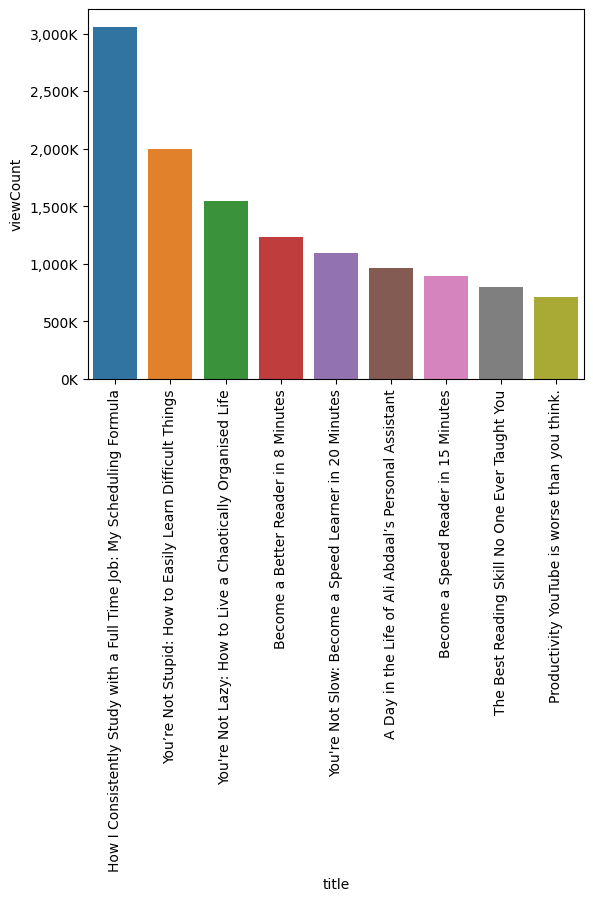

In [47]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

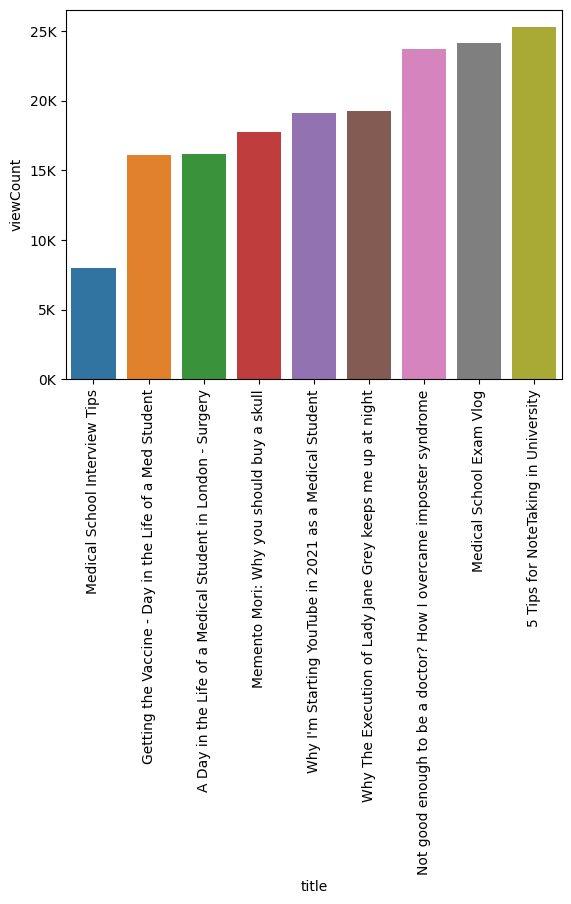

In [48]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

In [49]:
#sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

# Views vs. likes and comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

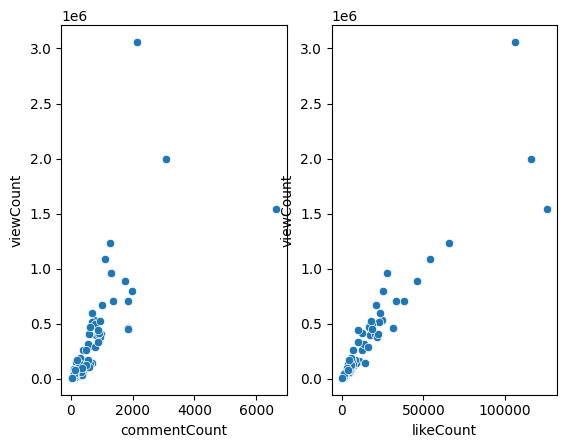

In [50]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

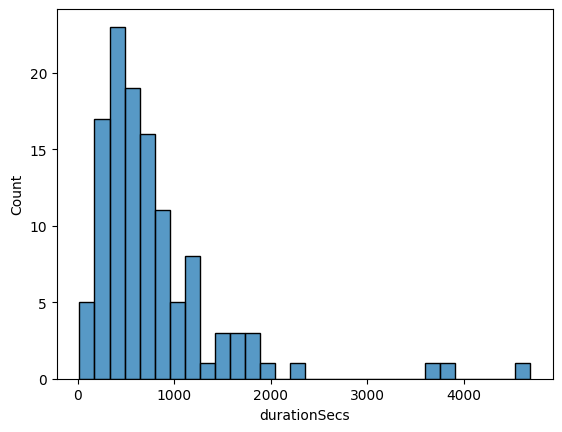

In [51]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

## Upload schedule

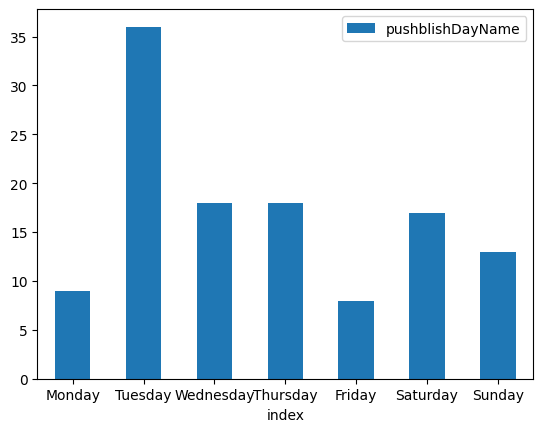

In [52]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)